## 3-class Classification Example

This example is an extension of the 2-class classification example. It is used for a classification task which involves classifying the input samples into three different classes, instead of two. It thus uses a two dimensional ensemble in the input layer and a three dimensional ensemble in the output layer. 

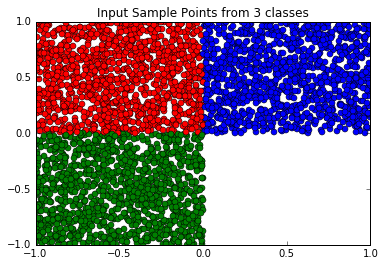

In [25]:
%matplotlib inline
import nengo
from nengo.dists import Uniform
from nengo.utils.ensemble import response_curves
import numpy as np
import matplotlib.pyplot as plt


def generateData(n):
    """ 
    generates a 2D dataset with n samples. 
    The third element of the sample is the label
    """
    xr = (np.random.rand(n)*2-1)/2-0.5
    yr = (np.random.rand(n)*2-1)/2+0.5
    xb = (np.random.rand(n)*2-1)/2+0.5
    yb = (np.random.rand(n)*2-1)/2+0.5
    xg = (np.random.rand(n)*2-1)/2-0.5
    yg = (np.random.rand(n)*2-1)/2-0.5
    
    inputs = []
    for i in range(len(xb)):
        inputs.append([xr[i],yr[i],[0,0,1]])
        inputs.append([xb[i],yb[i],[1,0,0]])
        inputs.append([xg[i],yg[i],[0,1,0]])
    return inputs


samples = 1200
data = generateData(samples)
plt.figure()
plt.title("Input Sample Points from 3 classes")
for x in data:
    if x[2][0] == 1:
        plt.plot(x[0], x[1], 'ob')
    elif x[2][1] == 1:
        plt.plot(x[0], x[1], 'og')
    elif x[2][2] == 1:
        plt.plot(x[0], x[1], 'or') 
    else:
        plt.plot(x[0], x[1], 'om') 


The above figure shows the input sample points from three classes. The network will be trained on some of these sample points and then tested on those remaining.

In [27]:
N = 100 #number of neurons
D_inp = 2
D_out = 3
factor = 11.0/12.0
sim_time = samples
model = nengo.Network('3-class Classification')
weights = np.random.randn(D_inp,D_out).transpose()  

with model:  
    
    def stim(t):
        for i in range(samples):
            if int(t) % samples <= i:
                return [data[i][0], data[i][1]]
        return 0
    
        
    def stim_ans(t):
        for i in range(samples):
            if int(t) % samples <= i:
                return data[i][2]
        return 0   
    
    
    #Define network inputs
    stim = nengo.Node(output=stim, size_out=D_inp)
    stim_ans = nengo.Node(output=stim_ans, size_out=D_out)
    
    #Create neural ensembles
    input = nengo.Ensemble(N*D_inp, dimensions=D_inp, label="input") 
    answer = nengo.Ensemble(N*D_out, dimensions=D_out, label="answer")
    correct_answer = nengo.Ensemble(N*D_out, dimensions=D_out, radius=2, label="correct_answer") 
    
    #Provide inputs to the network
    nengo.Connection(stim, input) 
    nengo.Connection(stim_ans, correct_answer)
    
    #Compute error for learning which gets inhibited
    error = nengo.Ensemble(N*D_out, dimensions=D_out, radius=2, label="error")  
    nengo.Connection(answer, error, transform=1)
    nengo.Connection(correct_answer, error, transform=-1)
    
    #Compute the actual error
    actual_error = nengo.Ensemble(N*D_out, dimensions=D_out, label="actual_error")
    nengo.Connection(answer, actual_error, transform=1)
    nengo.Connection(correct_answer, actual_error, transform=-1)
    
    #Specify the learning rule and the weight solver
    conn = nengo.Connection(input, answer, transform=weights, solver=nengo.solvers.LstsqL2(weights=True)) 
    conn.learning_rule_type={'my_pes': nengo.PES()}
    conn.learning_rule_type['my_pes'].learning_rate = 1e-4  
    
    #Provide error for learning
    error_conn = nengo.Connection(error, conn.learning_rule['my_pes'])    

    #Inhibit learning after the training period
    def inhibit(t):
        return 2.0 if t > int(factor*samples) else 0.0
     
    inhib = nengo.Node(inhibit)
    nengo.Connection(inhib, error.neurons, transform=[[-1]] * error.n_neurons)
       

In [3]:
with model:
    input_p = nengo.Probe(input, synapse=0.1)
    answer_p = nengo.Probe(answer, synapse=0.1)
    correct_answer_p = nengo.Probe(correct_answer, synapse=0.1)
    error_p = nengo.Probe(error, synapse=0.1)   
    actual_error = nengo.Probe(actual_error, synapse=0.1) 

In [4]:
sim = nengo.Simulator(model)
sim.run(sim_time)
t = sim.trange()

Simulation finished in 0:33:26.                                                 


(1090, 1150)

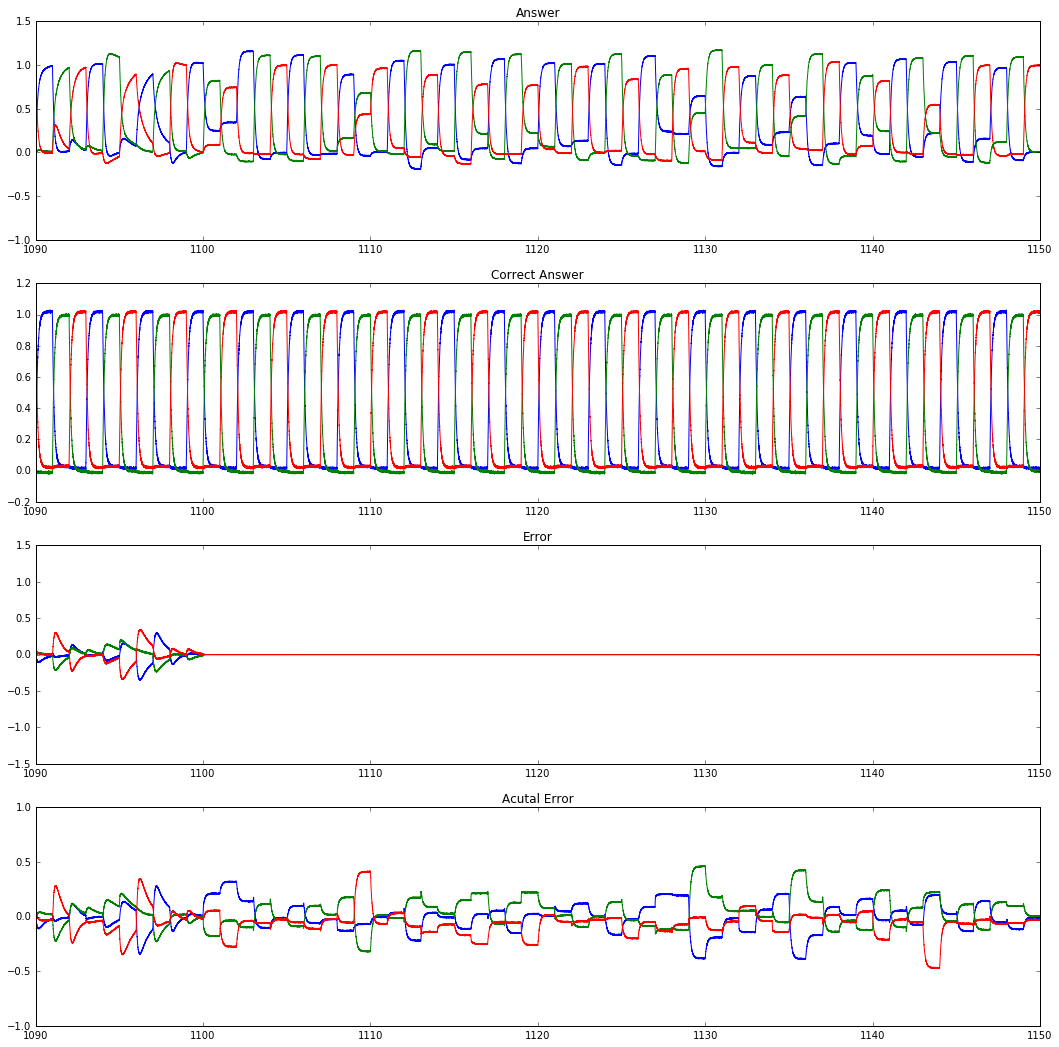

In [26]:
fig = plt.figure(figsize=(18,18))
p1 = fig.add_subplot(4,1,1)
p1.plot(t, sim.data[answer_p])
p1.set_title("Answer")
p1.set_xlim(1090,1150)

p2 = fig.add_subplot(4,1,2)
p2.plot(t, sim.data[correct_answer_p])
p2.set_title("Correct Answer")
p2.set_xlim(1090,1150)

p3 = fig.add_subplot(4,1,3)
p3.plot(t, sim.data[error_p])
p3.set_title("Error")
p3.set_xlim(1090,1150)

p4 = fig.add_subplot(4,1,4)
p4.plot(t, sim.data[actual_error])
p4.set_title("Acutal Error")
p4.set_xlim(1090,1150)

The 'Answer' plot shows the classification done by the network and the 'Correct Answer' plot shows the correct classification of the input samples. The "Error" plot shows the error used for learning, which was turned off at the beginning of the testing phase at t=1100s. The 'Actual Error' plot shows the error between the classification done by the network and the correct classification. The network was able to correctly classify most of the inputs.

In [ ]:
#Nengo GUI visualizer for visualizing the network
from nengo_gui.ipython import IPythonViz
IPythonViz(model)